<a href="https://colab.research.google.com/github/RuleOfNight/Badword-discord-Bot/blob/main/cifar10_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
!git clone https://github.com/cyizhuo/CIFAR-10-dataset.git

Cloning into 'CIFAR-10-dataset'...
remote: Enumerating objects: 60060, done.
remote: Counting objects: 100% (10047/10047), done.
remote: Compressing objects: 100% (10039/10039), done.
remote: Total 60060 (delta 5), reused 10047 (delta 5), pack-reused 50013 (from 1)
Receiving objects: 100% (60060/60060), 131.59 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (60001/60001), done.


In [3]:
import os
print(os.path.isdir('/content/CIFAR-10-dataset/train'))

True


In [4]:
# Transform dạng chuẩn ImageNet để dùng pretrained
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/CIFAR-10-dataset/train', transform=transform)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

test_data = datasets.ImageFolder(root='/content/CIFAR-10-dataset/test', transform=transform)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [5]:
image, label = train_data[0]

In [6]:
print(image.shape)
print(f"color_channels = {image.shape[0]}, height = {image.shape[1]}, width = {image.shape[2]}")

torch.Size([3, 224, 224])
color_channels = 3, height = 224, width = 224


In [7]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

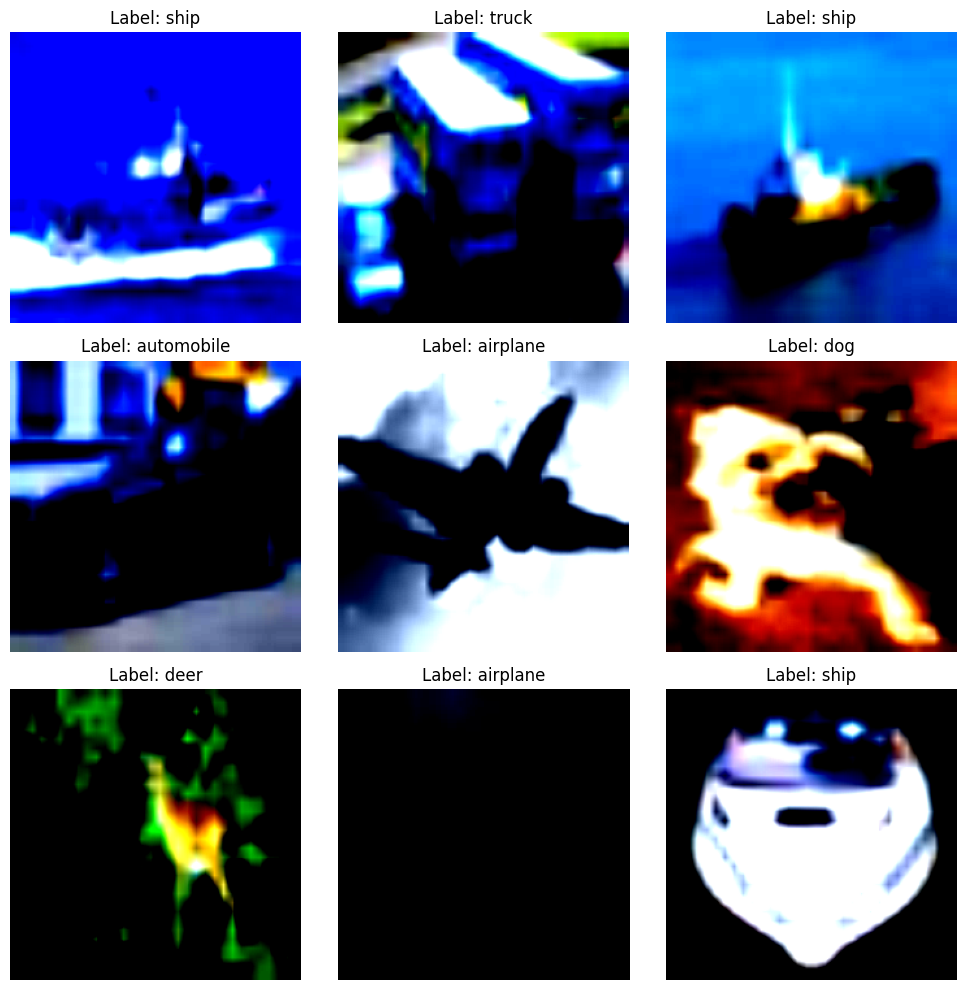

In [8]:
torch.manual_seed(42)
# Lấy batch từ loader
images, labels = next(iter(train_dataloader))


num_images = 9
images = images[:num_images]
labels = labels[:num_images]


fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = axes.flatten() # Chuyển ma trận axes thành mảng 1 chiều

for i in range(num_images):
    ax = axes[i]
    # Lấy axes hiện tại để vẽ hình ảnh


    image = images[i].numpy().transpose(1, 2, 0) # gpu -> cpu vì plt 0 hỗ trợ

    ax.imshow(image)
    ax.set_title(f"Label: {train_data.classes[labels[i]]}")
    ax.axis(False)

plt.tight_layout()
plt.show()

In [9]:
import torch.nn.functional as F
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [12]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [13]:
from tqdm.auto import tqdm

for batch, (X, y) in enumerate(tqdm(train_dataloader)):
    print(X.shape, y.shape)
    break

  0%|          | 0/3125 [00:00<?, ?it/s]

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [30]:
torch.manual_seed(42)
train_time_on_device = timer()

epochs = 10

model.to(device)
for epoch in tqdm(range(epochs)):
    print(f"---------------\nEpoch: {epoch+1}")

    train_loss = 0.0
    for X, y in train_dataloader:
        model.train()
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_dataloader)}")


model.eval()
correct = 0
total = 0
y_preds = []
y_true = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()


        y_preds.append(predicted.cpu())
        y_true.append(y.cpu())

print(f'Độ chính xác trong 10000 ảnh test: {100 * correct / total}%')

  0%|          | 0/10 [00:00<?, ?it/s]

---------------
Epoch: 1
Epoch 1/10, Loss: 0.02898411247341093
---------------
Epoch: 2
Epoch 2/10, Loss: 0.027506457541653435
---------------
Epoch: 3
Epoch 3/10, Loss: 0.022402867571910103
---------------
Epoch: 4
Epoch 4/10, Loss: 0.02128814737838289
---------------
Epoch: 5
Epoch 5/10, Loss: 0.01712075789478631
---------------
Epoch: 6
Epoch 6/10, Loss: 0.01065885817400877
---------------
Epoch: 7
Epoch 7/10, Loss: 0.008720420779730793
---------------
Epoch: 8
Epoch 8/10, Loss: 0.016929731743162275
---------------
Epoch: 9
Epoch 9/10, Loss: 0.012348439717597812
---------------
Epoch: 10
Epoch 10/10, Loss: 0.013132106692027773
Độ chính xác trong 10000 ảnh test: 91.54%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [16]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.0 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [17]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.3


In [18]:
print(f"y_preds: {y_preds}")

y_preds: [tensor([3, 6, 8, 5, 7, 1, 3, 6, 5, 0, 3, 3, 9, 1, 5, 8]), tensor([6, 2, 5, 9, 8, 1, 6, 1, 7, 4, 3, 7, 7, 7, 5, 7]), tensor([2, 9, 2, 3, 4, 2, 0, 8, 3, 2, 5, 4, 7, 9, 7, 8]), tensor([3, 4, 3, 4, 9, 5, 2, 9, 7, 4, 1, 7, 6, 9, 6, 7]), tensor([3, 6, 8, 9, 8, 2, 0, 4, 9, 1, 0, 1, 7, 6, 5, 0]), tensor([4, 8, 3, 5, 4, 9, 6, 7, 1, 6, 5, 8, 1, 3, 0, 7]), tensor([1, 7, 1, 0, 6, 3, 5, 7, 6, 5, 8, 7, 5, 5, 7, 1]), tensor([0, 9, 3, 9, 2, 6, 5, 4, 3, 7, 5, 3, 0, 3, 4, 1]), tensor([9, 8, 2, 7, 6, 6, 5, 3, 2, 0, 6, 3, 0, 3, 3, 2]), tensor([3, 5, 9, 5, 2, 3, 7, 0, 8, 0, 6, 5, 1, 7, 8, 5]), tensor([7, 0, 2, 6, 4, 7, 7, 8, 9, 8, 1, 5, 0, 3, 2, 9]), tensor([8, 7, 1, 0, 2, 4, 9, 9, 3, 7, 2, 6, 4, 7, 1, 3]), tensor([0, 4, 0, 2, 7, 5, 3, 2, 5, 5, 8, 9, 5, 9, 4, 3]), tensor([0, 1, 7, 8, 9, 7, 1, 9, 4, 3, 4, 7, 7, 0, 1, 5]), tensor([7, 1, 1, 0, 0, 3, 1, 0, 2, 9, 4, 1, 4, 2, 5, 4]), tensor([3, 8, 6, 2, 1, 2, 4, 4, 1, 4, 2, 3, 6, 5, 9, 5]), tensor([5, 2, 3, 9, 7, 2, 6, 8, 9, 8, 8, 2, 6, 7, 2, 8]), tens

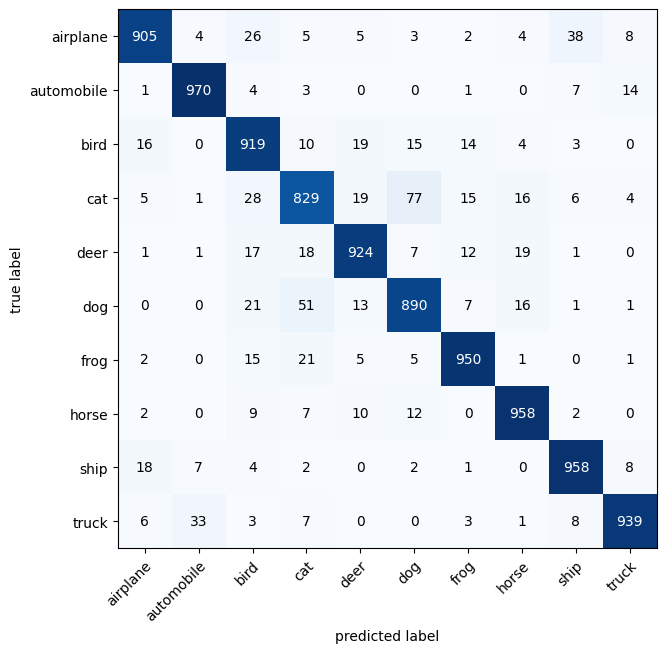

In [19]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

if len(y_preds) > 0:
    # Chuyển đổi danh sách các tensor thành một tensor duy nhất
    y_pred_tensor = torch.cat(y_preds)
    targets_tensor = torch.cat(y_true)

    # Confusion matrix
    cm = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    cm_tensor = cm(preds=y_pred_tensor, target=targets_tensor)


    fig, ax = plot_confusion_matrix(
        conf_mat=cm_tensor.cpu().numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )
    plt.show()
else:
    print("y_preds rỗng, không vẽ nổi.")

In [20]:
import numpy as np
# Cần là mảng 1 chiều
y_true = np.array(y_true).flatten()
y_preds = np.array(y_preds).flatten()

print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.91      0.93      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.88      0.92      0.90      1000
         cat       0.87      0.83      0.85      1000
        deer       0.93      0.92      0.93      1000
         dog       0.88      0.89      0.89      1000
        frog       0.95      0.95      0.95      1000
       horse       0.94      0.96      0.95      1000
        ship       0.94      0.96      0.95      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import joblib

filename = '/content/drive/MyDrive/Models/cifar10-reset18.joblib'
joblib.dump(model, filename)

['/content/drive/MyDrive/Models/cifar10-reset18.joblib']

In [25]:
import joblib

filename = '/content/drive/MyDrive/Models/cifar10-reset18.joblib'
loaded_model = joblib.load(filename)

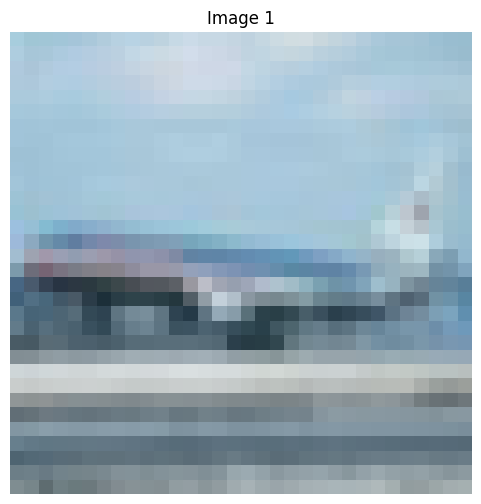

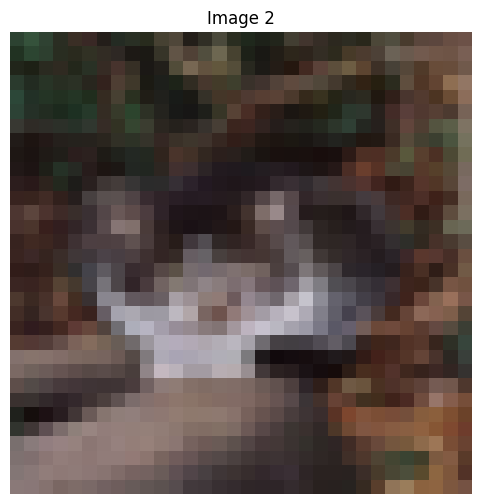

In [29]:
import cv2
import matplotlib.pyplot as plt


img1 = cv2.imread('/content/CIFAR-10-dataset/test/airplane/aeroplane_s_000045.png')


if img1 is None:
    print("Lỗi: Không tồn tại path")
else:
    # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img1_rgb)
    plt.title("Image 1")
    plt.axis(False)
    plt.show()



img2 = cv2.imread('/content/CIFAR-10-dataset/train/cat/alley_cat_s_000044.png')


if img2 is None:
    print("Lỗi: Không tồn tại path")
else:
    # Convert the image from BGR to RGB
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img2_rgb)
    plt.title("Image 2")
    plt.axis("off")
    plt.show()